# **Lab 2. Logistic regression**

Here we will build a logistic regression model to predict whether a student gets admitted into a university. We aim to determine the chance of admission of each student based on their results on two exams. For each training example, we have the scores on two exams and the admission decision. Our final model also aims to estimate the probability of admission based on the scores on those two exams.

## **1. Importing and plotting the dataset**
The first step of the pipeline involves the import and the exploration of the dataset. Firstly we import the libraries, giving them aliases.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Then we create a dataframe `df` by invoking the `read_csv()` function from `pandas` library, specifying the correct dataset.

In [2]:
# Import dataset
df = pd.read_csv("dataset.csv")

We also give a label for each column through the `columns` properties because the dataset is not labeled.

In [34]:
# Label dataset
df.columns = ['exam_score_1','exam_score_2','label']

### **1.1. Dataset exploration**
Python allows us to intuitively visualize the structure of the dataframe using the `head()` function, which displays a snapshot of what's inside the dataset. The output of the `head()` function shows the first five rows of the dataset, along with the column names.

In [4]:
# Snapshot of the dataset
df.head()

,exam_score_1,exam_score_2,label
0,30.286711,43.894998,0
1,35.847409,72.902198,0
2,60.182599,86.308552,1
3,79.032736,75.344376,1
4,45.083277,56.316372,0


Another way to explore the dataset is by using the `shape` property, which displays the number of rows and columns of the dataframe.

In [5]:
# Shape of the dataset
df.shape

(99, 3)

### **1.2. Dataset understanding**
The dataset has 99 rows and 3 columns.

The features of our problem are:
- `exam_score_1` the final mark for the exam 1;
- `exam_score_2` the final mark for the exam 2;

while the outcome is:
- `label` the admission decision: admitted (1) or not admitted (0).

As we can see from the dataset exploration, the outcome is binary thus the problem is a binary classification problem.

### **1.3. Checking null data**
Datasets often have inconsistencies, such as null values. We use the `isnull()` function combined with the `sum()` function to check for null values across all columns. This approach computes the number of null values for each column by summing accross the rows of the dataframe. Luckily enough, in this case we find no inconsistencies, as the sum of null values for all the features and the outcome is 0.

In [6]:
# Check null data
df.isnull().sum()

exam_score_1    0
exam_score_2    0
label           0
dtype: int64

### **1.4. Summary statistics**
Let us also display summary statistics of the dataset. For this purpose we can use the `describe()` function (we consider the transpose for a better visualization).

In [7]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
exam_score_1,99.0,65.957614,19.302009,30.058822,51.297736,67.319257,80.234877,99.827858
exam_score_2,99.0,66.102779,18.638875,30.603263,47.978125,66.589353,79.876423,98.869436
label,99.0,0.606061,0.491108,0.000000,0.000000,1.000000,1.000000,1.000000


For the binary outcome `label` we have to keep in mind that the summary statistics are not that meaningful. The only useful information are `count`, `min` and `max`.

### **1.5. Data visualization**
We can now visualize our dataset through the scatter plot between the `exam_score_1` (on the x-axis) and `exam_score_2` (on the y-axis) features and the `label` outcome (color of the dots). We use the `scatterplot()` function from `seaborn` to give some insights about our dataset.

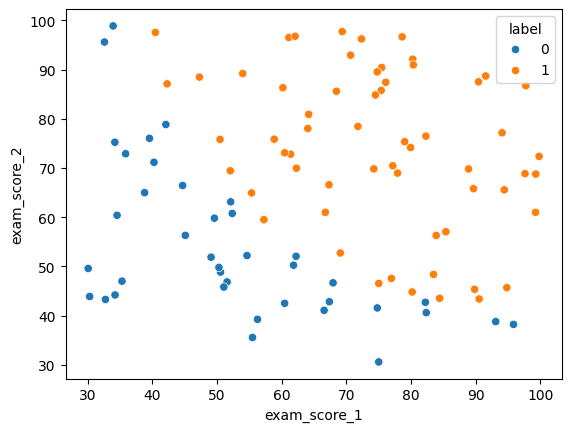

In [8]:
# Scatter plot 
pl = sns.scatterplot(data = df, x = 'exam_score_1', y = 'exam_score_2', hue = 'label')
plt.show(pl)

We can see that a sort of line can be imagined to divide the negative class (outcome 0) from the positive class (outcome 1).

## **2. Splitting data**
Once the dataset has been explored and well-understood, we need to split our data.

### **2.1. Training and testing**
In our pipeline, there is a training phase during which we build our model and a test phase to test if the trained model performs well on completely independent examples, different from the ones used during training. This independent test helps us evaluate the model's generalization error.

For this reason, we split the original dataframe `df` in two new dataframes `df_train` and `df_test` following a proper validation scheme. We decide the percentage `s_f` of the total examples to include in the training set so that the remaining goes into the test set. Typically, a common split is 80% for training and 20% for test, but this can vary depending on the dataset size and model requirements (70% for training and 30$ for test is also commonly used).

In [9]:
import math

# Percentage of split
s_f = 0.8

### **2.2. Choosing the split percentage**
Since we have 99 examples, our split will result in 79 examples for the training set and 20 examples for the test set. Using the `shape[0]` property we retrieve only the number of rows (examples) of the dataset. In whis way, we can determine the number of rows to allocate to the training set by multiplying the total number of rows by the fraction `s_f` (and consequently the number of rows to allocate to the test set).

The use of `floor()` and `ceil()` functions from the `math` library is crucial to prevent fractional values.

In [10]:
# Number of training examples
n_train = math.floor(s_f * df.shape[0])

# Number of test examples
n_test = math.ceil((1 - s_f) * df.shape[0])

print(n_train, n_test)

79 20


### **2.3. Training set and test set**
We can now split the original `df` dataframe into two new dataframes: `df_train` for training and `df_test` for testing.

In [11]:
# Training set
df_train = df[:n_train]

# Test set
df_test = df[n_train:]

To ensure that our dataset has been split correctly, we can use again the `head()` method to inspect the first few rows of `df_train`.

In [12]:
df_train.head()

,exam_score_1,exam_score_2,label
0,30.286711,43.894998,0
1,35.847409,72.902198,0
2,60.182599,86.308552,1
3,79.032736,75.344376,1
4,45.083277,56.316372,0


## **3. Model implementation**
We need to train our logistic regression model on the dataset using gradient descent.

### **3.1. Logistic regression hypothesis**
For the logistic regression we have to consider an hypothesis function that is given by:

$$ h_\theta(x) = g\left(\theta^Tx\right) $$

where as the logistic function $g(\cdot)$ we consider the sigmoid function:

$$ g(z) = \frac{1}{1 + e^{-z}} $$

For our purposes, we have to define the `sigmoid()` function:

In [13]:
def sigmoid(z):

    # Argument of the sigmoid
    z = np.array(z)
    
    # Sigmoid function
    return 1/(1 + np.exp(-z))

We can also plot the sigmoid function $g(z)$ in order to observe that this function is limited between $g(z) \in [0,1]$ and has a transition in $z=0$.

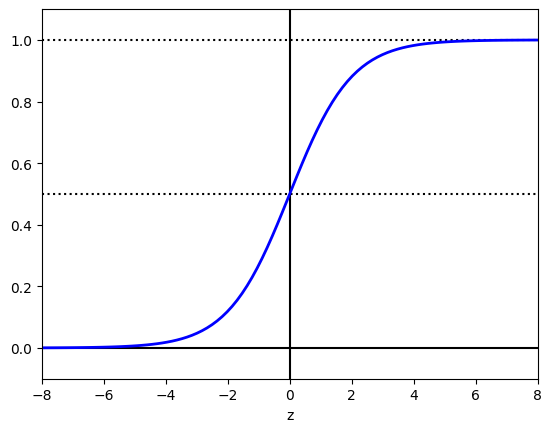

In [14]:
# Sigmoid function
z = np.linspace(-8,8,100)
sig = sigmoid(z)

# Bounds
plt.plot([-8,8], [0,0], 'k-')
plt.plot([-8,8], [0.5,0.5], 'k:')
plt.plot([-8,8], [1,1], 'k:')
plt.plot([0,0], [-1.1,1.1], 'k-')

# Plot
plt.plot(z, sig, 'b-', linewidth=2)
plt.xlabel('z')
plt.axis([-8,8, -0.1, 1.1])
plt.show()

### **3.3 Cost function**
The cost function for logistic regression is:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left( y^{(i)}\log(h_\theta(x^{(i)})) + (1 - y^{(i)} \log(1 - h_\theta(x^{(i)}))\right) $$

By considering the hypothesis function as the transformation of the product between the input matrix $X$ and the vector of parameters $\theta$:

$$h = g(X\theta) $$

the cost function can also be written in the vectorized form:

$$ J(\theta) = \frac{1}{m} \left(-y^T\log(h) - (1-y)^T\log(1-h)\right) $$

In this vectorized implementation, the gradient of the cost is a vector of the same length as the vector of parameters $\theta$, where the $j$-th element is defined as:

$$ \nabla J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left(h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} $$

We can consider as well the vectorized form by considering the entire input matrix $X$:

$$ \nabla J(\theta) = \frac{1}{m}X^T\left(g(X\theta) - y\right) $$

Without further ado we implement the `cost_function()` to compute the cost. This function will take as an input the input matrix `X`, the outcome vector `y`, and the vector of parameters `theta`. In particular, we define a small value for `epsilon` to be summed to the argument of the logarithm in order to avoid the logarithm of 0.


In [15]:
def cost_function(X, y, theta):
    # Small value
    epsilon = 1e-5

    # Number of samples
    m = y.shape[0]

    # Hypothesis function
    h = sigmoid(X.dot(theta))
    h = h.reshape(-1,1)

    # Cost
    J = (1/m) * (-y.T.dot(np.log(h+epsilon)) - (1-y).T.dot(np.log(1-h+epsilon)))

    return J

### **3.4. Gradient descent**
We define the `gradient_descent()` function to minimize the logistic regression cost function. This function will take as an input the input matrix `X`, the outcome vector `y`, the vector of parameters `theta`, the learning rate `alpha` and the maximum number of iterations `num_iters` (as the stopping condition).

In [16]:
def gradient_descent(X, y, theta, alpha, num_iters):
    # Number of samples
    m = y.shape[0]

    # Cost initialization
    J_history = np.zeros(shape=(num_iters,1))

    for i in range(0, num_iters):
        # Hypothesis function
        h = sigmoid(X.dot(theta))
        h = h.reshape(-1,1)

        # Update term
        delta = (1/m) * ((h - y).T.dot(X))

        # Parameters update
        theta = theta - (alpha * delta.T)

        # Cost history
        J_history[i] = cost_function(X, y, theta)

    return theta, J_history 

### **3.5. Preparing data**
To perform logistic regression, we need to add another dimension to our data to accomodate the $\theta_0$ intercept term. This term isn't directly present in the data, but it needs to be added. By adding the intercept term as an extra feature, often called a *dummy feature*, we can treat it the same way as other features in the model.

For our purposes, we need to specify the size `m` of the training set. Then we build the input matrix `X` by stacking the vector of the dummy feature to the actual features `exam_score_1` and `exam_score_2` from the training set (this is very important, otherwise we would make a mistake).

A common choice is to set the intercept terms to one (they will be updated during gradient descent).

In the same way we build the outcome vector `y` and finally we initialize the parameters vector `theta` to zero. The `reshape(-1,1)` function is used to ensure that all the previous vectors are treated as column vectors, in order to mantain compability between shapes.

In [17]:
# Number of training examples
m = df_train.shape[0]

# Design matrix
X = np.hstack((np.ones((m,1)), df_train.exam_score_1.values.reshape(-1,1), df_train.exam_score_2.values.reshape(-1,1)))

# Outcome vector
y = np.array(df_train.label.values).reshape(-1,1)

# Parameters vector
theta = np.zeros(shape = (X.shape[1],1))

Finally we define the learning rate `alpha` and the maximum number of iterations as a stopping condition .

In [18]:
# Learning rate
alpha = 0.001

# Maximum number of iterations
iterations = 1000

## **4. Model application**
We can finally apply the logistic regression model to our data. First, we run the `gradient_descent()` function to update the parameters `theta`.

In [19]:
# Gradient descent
theta, J_history = gradient_descent(X, y, theta, alpha, iterations)
print('Theta found by gradient descent:\n',theta)

Theta found by gradient descent:
 [[-0.07440541]
 [ 0.00389708]
 [ 0.0016744 ]]


### **4.1. Visualizing results**
We can use the parameters found by gradient descent to represent the decision boundary between the two classes of the outcome `label`.

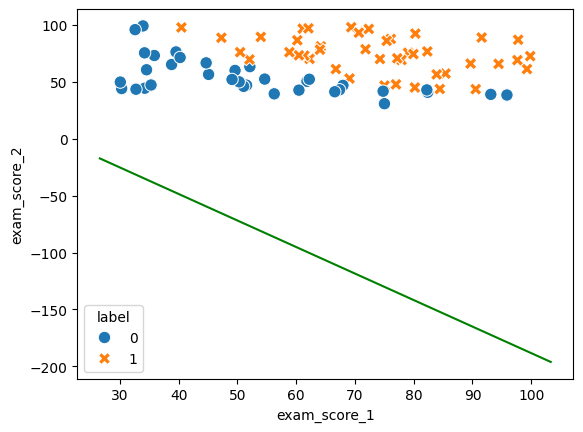

In [20]:
# Training data witht the decision boundary
ax = sns.scatterplot(x = 'exam_score_1', y = 'exam_score_2', hue = 'label', data = df_train, style = 'label', s = 80)
plot_x = np.array(ax.get_xlim())
plot_y = (-1/theta[2]*(theta[1]*plot_x + theta[0]))
plt.plot(plot_x, plot_y, 'g-')
plt.show(ax)

We can see that, by using the information about the parameters of the problem, our decision boundary is not well set. This means that our optimization algorithm fails to achieve the best partition of our dataset into two separable classes.

## **5. Model testing**
In order to have an objective evaluation, we can test the faulty model on the test set.


### **5.1. Preparing data**
Similarly to the training phase we build the input matrix `X_test` and the outcome vector `y_test`.


In [21]:
# Number of test samples
m_test = df_test.shape[0]

# Design matrix
X_test = np.hstack((np.ones((m_test,1)), df_test.exam_score_1.values.reshape(-1,1), df_test.exam_score_2.values.reshape(-1,1)))

# Outcome vector
y_test = np.array(df_test.label.values).reshape(-1,1)

Then we define a `predict()` function to compute the predictions vector `y_pred`. It is very important to understand how this function works:
- if the threshold computed by the sigmoid function is greater (or equal) than 0.5, the prediction will be true (admitted);
- if the threshold computed by the sigmoid function is smaller than 0.5, the prediction will be false (not admitted).

In [22]:
def predict(X, theta):

    # Compute predictions
    y_pred = [1 if sigmoid(X[i,:].dot(theta)) >= 0.5 else 0 for i in range(0, X.shape[0])]

    return y_pred

# Predictions vector
y_pred = predict(X_test, theta)

### **5.2. Performance metrics**
To take into account the classification performances of our model we can use the confusion matrix. After importing the `metrics` library from `sklearn`, we define the `confusion_matrix` object by putting in relationship the true label `y_test` and the predicted label `y_pred`.

Note that to display the confusion matrix we need to call the `ConfusionMatrixDisplay()` from `metrics`.

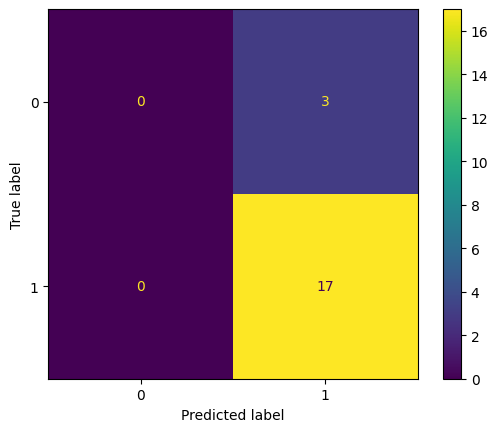

In [23]:
from sklearn import metrics

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

We can see that on the x-axis we have the predicted label, while on the y-axis we have the true label. From the confusion matrix we understand that our model correctly classifies all the true ones, but fails to classify all the true zeros, misclassifying them as ones. 

From the confusion matrix we can assess some performance metrics:
- Accuracy measures the proportion of correctly classified instances (both true positives and true negatives) among the total instances. It provides an overall measure of the model's performance.
- Sensitivity, also known as Recall, measures the proportion of actual positives that are correctly identified by the model. It focuses on how well the model detects positive instances.
- Specificity measures the proportion of actual negatives thare are correctly identified by the model. It focuses on how well the model avoids false positives.
- F1 score is the harmonic mean of Precision and Recall. It provides a single metric that balances the trade-off between the proportion of true potisives among the predicted positives and the proportion of true positives that are correctly identified by the model.

In [24]:
# Performance metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
sensitivity = metrics.recall_score(y_test, y_pred)
specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
f1_score = metrics.f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('F1 score:', f1_score)

Accuracy: 0.85
Sensitivity: 1.0
Specificity: 0.0
F1 score: 0.918918918918919


Results show some inconsistencies between the performance metrics. From accuracy we understand that the model is more or less acceptable. On the other hand from specificity, which has the lowest possible value, we understand that there is a huge margin of improvement.

### **5.3. Tuning the learning rate**
We can also explore the behaviour of our model by looking at the history of the cost function. In particular, we can evaluate different values of the learning rate in order to assess which one provides a better trend in the cost function. Let's compare $\alpha_1 = 0.8$ and $\alpha_2 = 0.001$.

C:\Users\giuse\AppData\Local\Temp\ipykernel_3260\1358645901.py:7: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


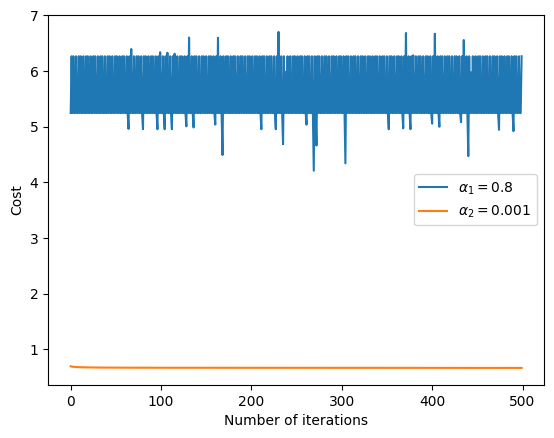

In [25]:
# Learning rates
alpha = [0.8, 0.001]

# Maximum number of iterations
num_iters = 500

# Comparison between learning rates
for i in range(0, len(alpha)):
    theta = np.zeros(shape=(X.shape[1],1))
    theta, J_history = gradient_descent(X, y, theta, alpha[i], num_iters)
    plt.plot(range(len(J_history)), J_history, label=fr'$\alpha_{i+1} = {alpha[i]}$')

plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

From this plot we understand that $\alpha_1=0.8$ keeps the cost function very high and unstable, while $\alpha_2 = 0.001$ seems to work fine.

### **5.4. Changing optimization algorithm**
Until now, we have built our own optimization function `gradient_descent()`. In some cases, like ours, it is simpler and much more convenient to define an external optimization function. For our purposes we use the function `minimize()` from `scipy`.

In [26]:
import scipy.optimize as opt

Before going on, we need to redefine the `cost_function()` to make it compatible with the optimizer.

In [27]:
def cost_function(theta, X, y):
    # Number of samples
    m = y.shape[0]

    # Trick to make optimizer work
    theta = theta[:, np.newaxis]

    # Hypothesis function
    h = sigmoid(X.dot(theta))

    # Cost function
    J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h)))

    # Gradient
    grad = (1/m) * (h-y).T.dot(X)

    return J, grad

For example, we can choose the truncated Newton (TNC) algorithm to minimize the cost function.

In [28]:
def optimize_theta(X, y, theta):
    # Optimization algorithm
    opt_results = opt.minimize(cost_function, theta, args=(X, y), method='TNC', jac=True, options={'maxfun':400})
    
    return opt_results['x'], opt_results['fun']

Let's now run the `optimize_theta()` function instead of `gradient_descent()` to find the best values for the parameters. Before doing that, let us recall the trick we used in the new `cost_function()` to make things work. We need to adjust the shape of the vector of parameters `theta`.

In [29]:
# Shaping the vector of parameters
theta = np.zeros(shape=(X.shape[1],))

# Optimization
opt_theta, cost = optimize_theta(X, y, theta)
print('theta:\n', opt_theta.reshape(-1,1))

theta:
 [[-25.73896186]
 [  0.20851891]
 [  0.20354526]]


### **5.6. Understanding results**
The new parameters computed by the new `optimize_theta()` function differ a lot from the ones we computed using `gradient_descent()` function. This probably means that our model capabilities have changed as well. We can check that by plotting the new decision boundary:

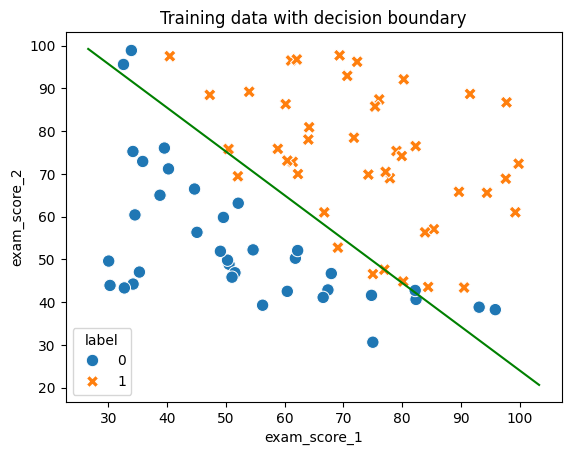

In [30]:
# Training data witht the decision boundary
ax = sns.scatterplot(x='exam_score_1', y='exam_score_2', hue='label', data=df_train, style='label', s=80)
plt.title('Training data with decision boundary')
plot_x = np.array(ax.get_xlim())
plot_y = (-1/opt_theta[2]*(opt_theta[1]*plot_x + opt_theta[0]))
plt.plot(plot_x, plot_y, 'g-')
plt.show(ax)

We can see that the decision boundary is now separating properly the training samples, so the geometrical problem is well set.

Turns out the problem was not the learning rate, or the model itself, but the optimization algorithm used to compute the optimal values of the regression parameters. Again, we have to test our freshly-updated model to evaluate its generalization capabilities.

In [31]:
# Predicted probabilities
y_pred_prob = predict(X_test, opt_theta)

Let us now consider the new confusion matrix.

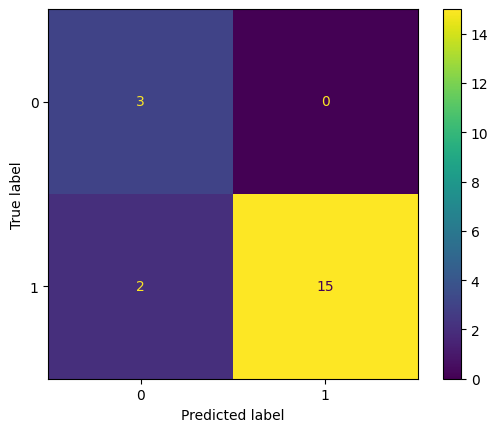

In [32]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_prob)

# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

We can see that all the true zero samples are correctly classified as zero samples, while only two true one samples are misclassified as zero samples.

In [33]:
# Performance metrics
accuracy = metrics.accuracy_score(y_test, y_pred_prob)
sensitivity = metrics.recall_score(y_test, y_pred_prob)
specificity = metrics.recall_score(y_test, y_pred_prob, pos_label=0)
f1_score = metrics.f1_score(y_test, y_pred_prob)

print('Accuracy:', accuracy)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('F1 score:', f1_score)

Accuracy: 0.9
Sensitivity: 0.8823529411764706
Specificity: 1.0
F1 score: 0.9375


If we take a look at the improved performance metrics, specificity has rised from 0 (minimum value) to 1 (maximum values).